In [45]:
## IMPORTACIÓN GENERAL DE LIBRERIAS.
import re 
import sys
import json
import nltk
import geocoder
import requests
import warnings
import descartes

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import datetime as DT

#import geopandas as gpd
import matplotlib.pyplot as plt

# SKLEARN.
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# RANDOM FOREST.
from urllib.request import urlopen
from shapely.geometry import Point, Polygon
from sklearn.ensemble import RandomForestClassifier

# XGBOOST.
from xgboost import XGBClassifier
import xgboost as xgb

In [46]:
#NLTK: https://www.nltk.org
from langdetect import detect
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

#WORDCLOUD
from PIL import Image
from wordcloud import WordCloud

# CONFIGURACIÓN.
%matplotlib inline
plt.style.use('default')
pd.options.display.float_format = '{:20,.2f}'.format
warnings.filterwarnings('ignore')
sns.set(style="whitegrid") 
plt.rcParams['figure.figsize'] = (15, 10)
np.set_printoptions(threshold=sys.maxsize)

### =====================================================================
### RANDOM FOREST.
### =====================================================================

In [47]:
#OBTENEMOS LOS CSVs YA PROCESADOS EN LA PRIMER ETAPA.
original_train = pd.read_csv('data/processed/original_train.csv')
original_test = pd.read_csv('data/processed/original_test.csv')
original_sample_submission = pd.read_csv('data/sample_submission.csv')
#MARCAMOS EL TAGET/LABEL A TRABAJAR EN TRAIN.
original_train_label = np.array(original_train['target'])
original_train_features = original_train.drop('target', axis = 1)
original_train_features = original_train_features.drop('id', axis = 1)

In [48]:
original_train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   keyword_0         7613 non-null   int64  
 1   keyword_1         7613 non-null   int64  
 2   keyword_2         7613 non-null   int64  
 3   keyword_3         7613 non-null   int64  
 4   keyword_4         7613 non-null   int64  
 5   keyword_5         7613 non-null   int64  
 6   keyword_6         7613 non-null   int64  
 7   keyword_7         7613 non-null   int64  
 8   keyword_8         7613 non-null   int64  
 9   length            7613 non-null   int64  
 10  totalwords        7613 non-null   int64  
 11  lenXword          7613 non-null   float64
 12  matches           7613 non-null   int64  
 13  hashtagsCantidad  7613 non-null   int64  
 14  preguntas         7613 non-null   int64  
 15  simbolos          7613 non-null   int64  
 16  conUbicacion      7613 non-null   int64  


In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(original_train_features,original_train_label,test_size=0.2,random_state=123)

In [50]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train,Y_train)
preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test,preds))
print('RMSE: %f' % (rmse))

RMSE: 0.531354


In [51]:
rf_model = RandomForestClassifier(random_state=1,n_estimators=5)
rf_model.fit(X_train,Y_train)
preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test,preds))
print('RMSE: %f' % (rmse))

RMSE: 0.571827


In [52]:
rf_model = RandomForestClassifier(random_state=1,max_features=10)
rf_model.fit(X_train,Y_train)
preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test,preds))
print('RMSE: %f' % (rmse))

RMSE: 0.547183


In [53]:
rf_model = RandomForestClassifier(random_state=1,n_estimators=5,max_features=10)
rf_model.fit(X_train,Y_train)
preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test,preds))
print('RMSE: %f' % (rmse))

RMSE: 0.572401


In [54]:
rf_model = RandomForestClassifier(random_state=1,max_features=10,max_depth=50)
rf_model.fit(X_train,Y_train)
preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test,preds))
print('RMSE: %f' % (rmse))

RMSE: 0.547183


In [61]:
rf_model = RandomForestClassifier(n_jobs=2,random_state=1,max_features=5,max_depth=35, min_samples_split=2)
rf_model.fit(X_train,Y_train)
preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test,preds))
print('RMSE: %f' % (rmse))

RMSE: 0.546583


In [64]:
#OBTENEMOS LOS CSVs YA PROCESADOS EN LA PRIMER ETAPA.
original_train = pd.read_csv('data/processed/original_train.csv')
original_test = pd.read_csv('data/processed/original_test.csv')
original_sample_submission = pd.read_csv('data/sample_submission.csv')
#MARCAMOS EL TAGET/LABEL A TRABAJAR EN TRAIN.
original_train_label = np.array(original_train['target'])
original_train_features = original_train.drop('target', axis = 1)
original_train_features = original_train_features.drop('id', axis = 1)
original_test = original_test.drop('id', axis = 1)

In [65]:
rf_model = RandomForestClassifier(n_jobs=2,random_state=1,max_features=10,max_depth=50, min_samples_split=5)
rf_model.fit(original_train_features,original_train_label)
preds = rf_model.predict(original_test)

In [66]:
rf_model.feature_importances_

array([0.        , 0.01878283, 0.01983921, 0.01873306, 0.01883211,
       0.02142734, 0.01965867, 0.01874049, 0.0182578 , 0.09351189,
       0.03924868, 0.14376356, 0.07294343, 0.02865338, 0.02224807,
       0.02084429, 0.01596285, 0.00376281, 0.12412032, 0.03557914,
       0.12153502, 0.03529576, 0.08825932])

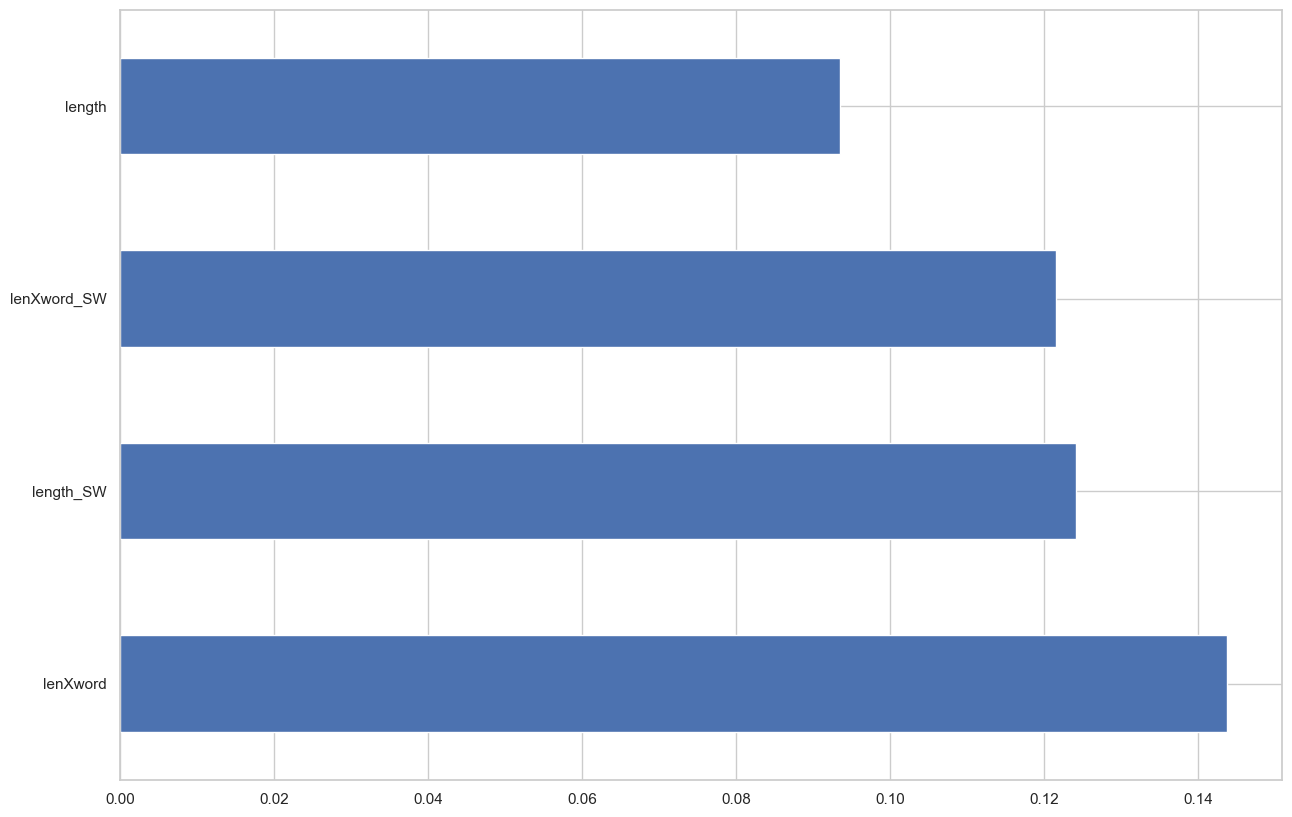

In [67]:
feat_importances = pd.Series(rf_model.feature_importances_, index=original_train_features.columns)
feat_importances.nlargest(4).plot(kind='barh')

In [68]:
preds

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,

In [69]:

original_test = pd.read_csv('data/processed/original_test.csv')
kaggle_submission = pd.DataFrame(original_test,columns = ['id'])
kaggle_submission["target"] = preds
kaggle_submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [72]:
kaggle_submission.to_csv('data/submits/submission_RF_09.csv',index=False) 
#RESULTADO: 0.74

In [73]:
#=========== GRID SEARCH HYPER PARÁMETROS.

#OBTENEMOS LOS CSVs YA PROCESADOS EN LA PRIMER ETAPA.
original_train = pd.read_csv('data/processed/original_train.csv')
original_test = pd.read_csv('data/processed/original_test.csv')
original_sample_submission = pd.read_csv('data/sample_submission.csv')
#MARCAMOS EL TAGET/LABEL A TRABAJAR EN TRAIN.
original_train_label = np.array(original_train['target'])
original_train_features = original_train.drop('target', axis = 1)
original_train_features = original_train_features.drop('id', axis = 1)
original_test = original_test.drop('id', axis = 1)

In [79]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}# Create a based model
rf = RandomForestClassifier() # Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [81]:
# Fit the grid search to the data
grid_search.fit(original_train_features, original_train_label)

grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   4.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_sa

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   4.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, mi

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   5.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   6.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   6.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   5.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   5.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   5.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_feature

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   2.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   4.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_feature

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   3.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2,

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, 

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, 

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, 

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, 

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   5.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fe

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   6.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   8.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, ma

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   3.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   8.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   8.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, m

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   6.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, ma

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_fe

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_fea

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 26.9min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 200}

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)
#[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 26.9min finished

#{'bootstrap': True,
# 'max_depth': 110,
# 'max_features': 2,
# 'min_samples_leaf': 5,
# 'min_samples_split': 10,
# 'n_estimators': 200}

In [84]:
rf_model = RandomForestClassifier(bootstrap=True,max_depth=110,max_features=2,min_samples_leaf=5,min_samples_split=10,n_estimators=200)
rf_model.fit(original_train_features,original_train_label)
preds = rf_model.predict(original_test)

In [85]:
kaggle_submission = pd.DataFrame(original_test,columns = ['id'])
kaggle_submission["target"] = preds
kaggle_submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,0
3261,10874,1


In [86]:
kaggle_submission.to_csv('data/submits/submission_RF_06_GS.csv',index=False) 

### =====================================================================
### FIN DEL RANDOM FOREST.
### =====================================================================

In [74]:
original_train = ''
original_test = ''
original_sample_submission = ''

### =====================================================================
### XGBOOST.
### =====================================================================

In [81]:
#OBTENEMOS LOS CSVs YA PROCESADOS EN LA PRIMER ETAPA.
original_train = pd.read_csv('data/processed/original_train.csv')
original_test = pd.read_csv('data/processed/original_test.csv')
original_sample_submission = pd.read_csv('data/sample_submission.csv')

In [82]:
# Resto de los labels.
Y = np.array(original_train['target'])
X = original_train.drop('target', axis = 1)
X = X.drop('id', axis = 1)
original_test = original_test.drop('id', axis = 1)

In [136]:
from sklearn.model_selection import RandomizedSearchCV

In [140]:
# grid search
model = XGBClassifier()

param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'min_child_weight': np.arange(0.0001, 0.5, 0.001),
        'gamma': np.arange(0.0,40.0,0.005),
        'learning_rate': np.arange(0.0005,0.3,0.0005),
        'subsample': np.arange(0.01,1.0,0.01),
        'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
        'colsample_bytree': np.arange(0.1,1.0,0.01)
}

kfold = KFold(n_splits=10, shuffle=True, random_state=10)
grid_search = RandomizedSearchCV(model, param_grid, scoring="accuracy", n_iter = 500, cv=kfold)
grid_result = grid_search.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]

# TIEMPO APROXIMADO 4 HORAS.

Best: 0.761985 using {'subsample': 0.61, 'min_child_weight': 0.2041, 'max_depth': 10, 'learning_rate': 0.127, 'gamma': 3.005, 'colsample_bytree': 0.6699999999999997, 'colsample_bylevel': 1.0}


NameError: name 'time' is not defined

In [142]:
grid_result.best_params_

{'subsample': 0.61,
 'min_child_weight': 0.2041,
 'max_depth': 10,
 'learning_rate': 0.127,
 'gamma': 3.005,
 'colsample_bytree': 0.6699999999999997,
 'colsample_bylevel': 1.0}

In [83]:
# MODELO ENSAMBLE 3.
trainX_M3, testX_M3, trainY_M3, testY_M3 = train_test_split(X, Y, test_size=0.2, random_state=123)
data_dmatrix_inst = xgb.DMatrix(data=trainX_M3,label=trainY_M3)
model3 = xgb.XGBClassifier(objective = 'binary:logistic', 
                          n_estimators = 200,
                          min_child_weight = 0.2041,
                          learning_rate = 0.127,
                          max_depth = 10,
                          colsample_bytree = 0.6699999999999997, 
                          colsample_bylevel = 1.0,
                          subsample = 0.61)

In [84]:
model3.fit(trainX_M3,trainY_M3)
pred_M3 = model3.predict(testX_M3)

In [85]:
# AHORA LO HACEMOS COMPLETO:
model3.fit(X,Y)
prediccion = model3.predict(original_test)

In [86]:

original_test = pd.read_csv('data/processed/original_test.csv')
kaggle_submission = pd.DataFrame(original_test,columns = ['id'])
kaggle_submission["target"] = prediccion
kaggle_submission

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [87]:
kaggle_submission.to_csv("data/submits/submission_XGB_09.csv", index=False)

### =====================================================================
### FIN DEL XGBOOST.
### =====================================================================